In [ ]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1]:
import os

os.listdir("/kaggle/input")


['global-temperatures']

In [2]:
import os

os.listdir("/kaggle/input/global-temperatures")


['GlobalTemperatures.csv']

In [3]:
import pandas as pd

global_temp = pd.read_csv(
    "/kaggle/input/global-temperatures/GlobalTemperatures.csv"
)

print(global_temp.head())
print(global_temp.shape)
print(global_temp.columns)
print(global_temp.isnull().sum())


           dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
0  1750-01-01                   3.034                              3.574   
1  1750-02-01                   3.083                              3.702   
2  1750-03-01                   5.626                              3.076   
3  1750-04-01                   8.490                              2.451   
4  1750-05-01                  11.573                              2.072   

   LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
0                 NaN                            NaN                 NaN   
1                 NaN                            NaN                 NaN   
2                 NaN                            NaN                 NaN   
3                 NaN                            NaN                 NaN   
4                 NaN                            NaN                 NaN   

   LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
0                 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [8]:
#Data Preparation
def wrangle(df):
    df = df.copy()
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)

In [12]:
# Data Preparation
def wrangle(df):
    df = df.copy()

    # Drop uncertainty columns
    df = df.drop(columns=[
        "LandAverageTemperatureUncertainty",
        "LandMaxTemperatureUncertainty",
        "LandMinTemperatureUncertainty",
        "LandAndOceanAverageTemperatureUncertainty"
    ])

    # Convert Celsius to Fahrenheit
    def converttemp(x):
        return (x * 1.8) + 32

    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)

    # Date handling
    df["dt"] = pd.to_datetime(df["dt"])
    df["Year"] = df["dt"].dt.year

    # Keep reliable years only
    df = df[df["Year"] >= 1850]

    # Cleanup
    df = df.drop(columns=["dt"])
    df = df.set_index("Year")
    df = df.dropna()

    return df


In [13]:
global_temp = wrangle(global_temp)
print(global_temp.head())
print(global_temp.isnull().sum())


      LandAverageTemperature  LandMaxTemperature  LandMinTemperature  \
Year                                                                   
1850                 33.3482             46.8356             26.2292   
1850                 37.5278             49.9460             27.8762   
1850                 40.9172             50.6246             28.5710   
1850                 44.9906             55.2812             33.8324   
1850                 50.0072             60.1790             38.8598   

      LandAndOceanAverageTemperature  
Year                                  
1850                         55.0994  
1850                         56.4584  
1850                         57.2774  
1850                         58.4006  
1850                         59.9126  
LandAverageTemperature            0
LandMaxTemperature                0
LandMinTemperature                0
LandAndOceanAverageTemperature    0
dtype: int64


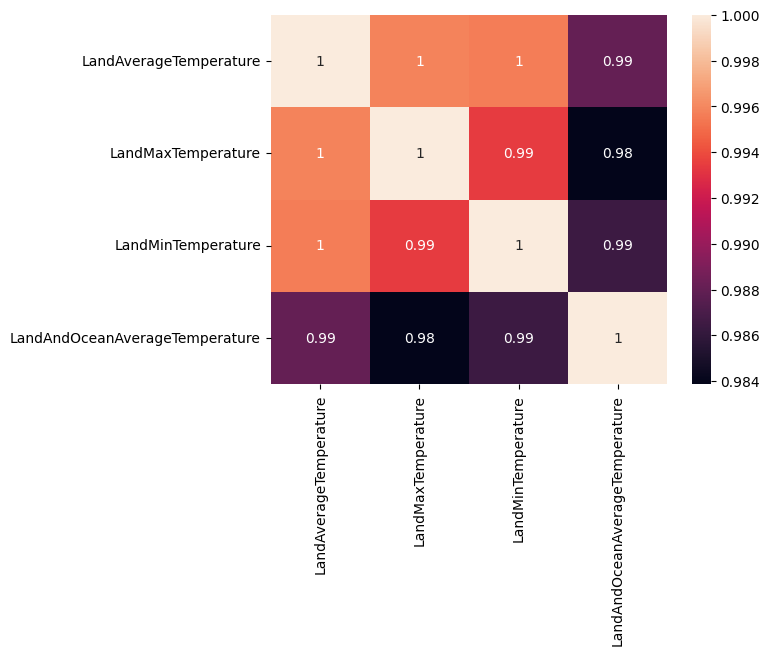

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
corrMatrix = global_temp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [18]:
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
x = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

In [19]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.25, random_state=42)
print(xtrain.shape)
print(xval.shape)
print(ytrain.shape)
print(yval.shape)

(1494, 3)
(498, 3)
(1494,)
(498,)


In [20]:
from sklearn.metrics import mean_squared_error
ypred = [ytrain.mean()] * len(ytrain)
print("Baseline MAE: ", round(mean_squared_error(ytrain, ypred), 5))

Baseline MAE:  5.29374


In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor

forest = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)

forest.fit(xtrain, ytrain)


Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

In [ ]:
y_pred = forest.predict(xval)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(yval, y_pred)
rmse = np.sqrt(mean_squared_error(yval, y_pred))
r2 = r2_score(yval, y_pred)

print("Model Evaluation Results")
print("------------------------")
print("MAE  :", mae)
print("RMSE :", rmse)
print("R²   :", r2)


Model Evaluation Results
------------------------
MAE  : 0.2442967590361433
RMSE : 0.318657889810123
R²   : 0.9802546321843024


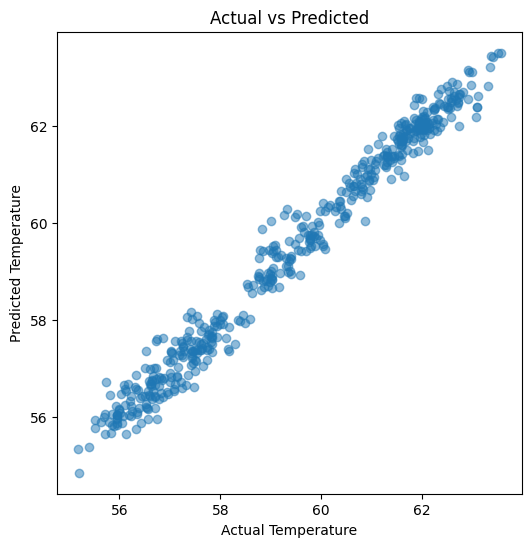

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(yval, y_pred, alpha=0.5)
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Actual vs Predicted")
plt.show()
